In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

5


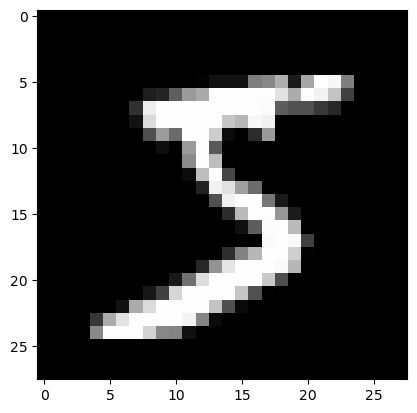

In [2]:
train_data, test_data = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train = train_data[0].reshape(-1,784).astype(float) / 255
y_train = train_data[1]
print(y_train[0])
plt.imshow(train_data[0][0], cmap='gray')

In [11]:
train_data[0].shape # the input of the training set: 6000 training data, therefore 6000 arrays of (28, 28)
train_data[1].shape # the output of the training set: 6000 training data, therefore 6000 results

(60000,)

# 4. Model

In [54]:
# source: https://keras.io/guides/training_with_built_in_methods/

inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs) # relu: non linear, weight: 784*32
x = layers.Dense(32, activation="relu", name="dense_2")(x) # fully connected layers, calculating the weights between the nodes, weight: 32*32
outputs = layers.Dense(10, activation=None, name="predictions")(x) # output results of size 10
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Question 4.1

We divide into two situation that we consider:

1. Between every two layers, we add one offset parameter, then:
    - From Input layer to first Dense layer, there is $(784+1)\times 32 = 25120$ parameters
    - From first Dense layer to the second, there is $(32+1)\times 32=1056$ parameters
    - From second Dense layer to prediction layer, there is $(32+1)\times 10=330$ parameters

Therefore, in total there are $26506$ parameters, which is in line with what the model summary gives us.

2. Between every two layers, we don't add offset parameter
    - From Input layer to first Dense layer, there is $784\times 32 = 25088$ parameters
    - From first Dense layer to the second, there is $32\times 32=1024$ parameters
    - From second Dense layer to prediction layer, there is $32\times 10=320$ parameters

Therefore, in total there are $26432$ parameters.

In [16]:
# untrained model
logits = model(x_train)
np.argmax(logits, 1)[0:100] # take the max along axis=1

array([2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 0,
       2, 7, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 2, 7, 2, 2, 2, 2, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 3, 0, 0,
       0, 0, 1, 0, 0, 2, 2, 3, 2, 2, 2, 2], dtype=int64)

In [17]:
# what we would like to get
y_train[0:100]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1], dtype=uint8)

example code for one batch single epoch training

In [30]:
## Computing a stochastic gradient

# Source: https://keras.io/guides/writing_a_training_loop_from_scratch/
# correct source: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch

# Example of gradient computation using automatic differentiation

x_train_batch = x_train[:8]
y_train_batch = y_train[:8]
with tf.GradientTape() as tape: # record all the intermediate values
        # Run the forward pass of the layer.
        # The operations that the layer applies
        # to its inputs are going to be recorded
        # on the GradientTape.
        # logits = model(x_train_batch)  # Logits for this minibatch
        logits = model(x_train_batch, training=True)

        # Compute the loss value for this minibatch.
        loss_value = loss(y_train_batch, logits)

# Use the gradient tape to automatically retrieve
# the gradients of the trainable variables with respect to the loss.
grad = tape.gradient(loss_value, model.trainable_weights) # forward propagation: intermediate values for jacobienne, length of 6
# trainable_weights length 6



## Updating weights

def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)


## Evaluate model
samples_for_evaluation = np.random.randint(0, 10000, 1000)
logits = model(x_train[samples_for_evaluation])
loss(y_train[samples_for_evaluation], logits).numpy()


6


2.3234298

# 5. Stochastic Gradient Descent

Here we use the documentation hint to create batches of 8 instead of using the basic function code.

And we don't specifically set a validation set.

In [35]:
# this update weight is similar to an SGD optimizer, where update is the learning rate
def update_weights(model, update):
    new_weights = model.trainable_weights.copy()
    for i in range(len(new_weights)):
        new_weights[i] = new_weights[i] + update[i]
    model.set_weights(new_weights)

In [55]:
# prepare the training dataset
batch_size = 1
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [56]:
# learning rate
lr = 0.01
step_list = []
loss_list = []


Start of epoch 0
Training loss (for one batch) at step 0: 2.4174
Seen so far: 1 samples
Training loss (for one batch) at step 100: 2.5457
Seen so far: 101 samples
Training loss (for one batch) at step 200: 1.9209
Seen so far: 201 samples
Training loss (for one batch) at step 300: 1.1560
Seen so far: 301 samples
Training loss (for one batch) at step 400: 0.7062
Seen so far: 401 samples
Training loss (for one batch) at step 500: 0.7770
Seen so far: 501 samples
Training loss (for one batch) at step 600: 1.6367
Seen so far: 601 samples
Training loss (for one batch) at step 700: 0.0678
Seen so far: 701 samples
Training loss (for one batch) at step 800: 3.9381
Seen so far: 801 samples
Training loss (for one batch) at step 900: 0.0023
Seen so far: 901 samples
Training loss (for one batch) at step 1000: 0.2421
Seen so far: 1001 samples
Training loss (for one batch) at step 1100: 0.9077
Seen so far: 1101 samples
Training loss (for one batch) at step 1200: 1.2892
Seen so far: 1201 samples
Train

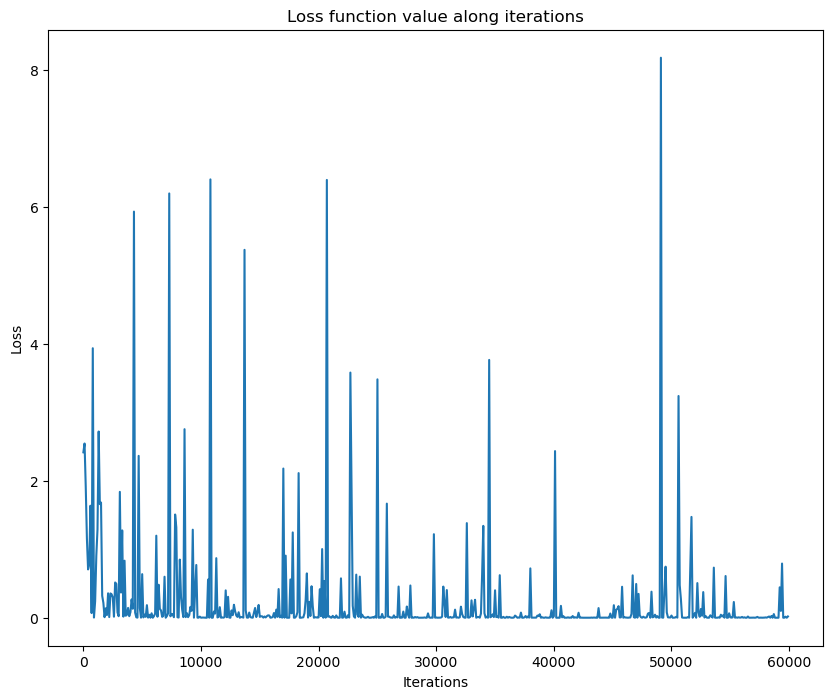

In [57]:
epochs = 1 # training epochs
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights) # length 6, in line with trainable_weights

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        # optimizer.apply_gradients(zip(grads, model.trainable_weights))
        update_item = list()
        for i in range(len(grads)):
            update_item.append(-lr * grads[i])
        update_weights(model, update_item)

        # Log every 400 batches.
        if step % 100 == 0:
            step_list.append(step)
            loss_list.append(float(loss_value))
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
plt.figure(figsize=(10,8))
plt.plot(step_list, loss_list)
plt.title("Loss function value along iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# 6. Empirical Risk Minimization

What is different in this part from the previous part is that, in the previous part, we compute the loss each time on a single sample and update the weight with the gradient on this sample. In the current part, we compute the loss from a batch, therefore, this represents the empirical risk.

Therefore, what we need to modify from our previous code is change the batch size from 1 to more, and run more epochs.

In [72]:
# reset model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs) # relu: non linear, weight: 784*32
x = layers.Dense(32, activation="relu", name="dense_2")(x) # fully connected layers, calculating the weights between the nodes, weight: 32*32
outputs = layers.Dense(10, activation=None, name="predictions")(x) # output results of size 10
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# prepare the training dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [74]:
# learning rate
lr = 0.001
step_list = []
loss_list = []


Start of epoch 0
Training loss (for one batch) at step 0: 2.3151
Seen so far: 64 samples
Training loss (for one batch) at step 400: 2.2154
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 2.1530
Seen so far: 51264 samples

Start of epoch 1
Training loss (for one batch) at step 0: 2.0869
Seen so far: 64 samples
Training loss (for one batch) at step 400: 1.9793
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 1.8797
Seen so far: 51264 samples

Start of epoch 2
Training loss (for one batch) at step 0: 1.7625
Seen so far: 64 samples
Training loss (for one batch) at step 400: 1.7347
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 1.5697
Seen so far: 51264 samples

Start of epoch 3
Training loss (for one batch) at step 0: 1.3395
Seen so far: 64 samples
Training loss (for one batch) at step 400: 1.2162
Seen so far: 25664 samples
Training loss (for one batch) at step 800: 1.2536
Seen so far: 51264 samples

Start of epoch 4
Traini

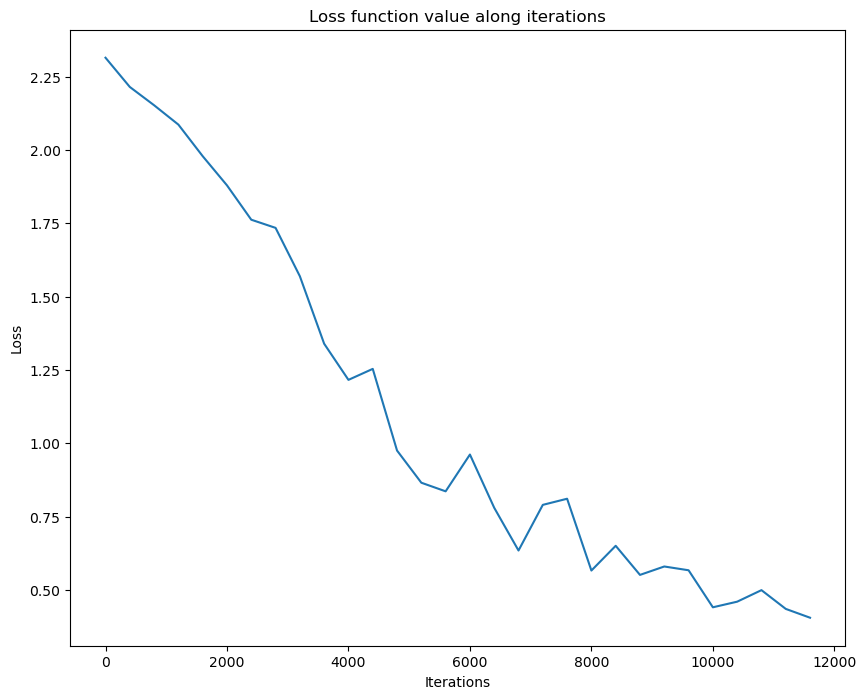

In [75]:
epochs = 10 # training epochs
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights) # length 6, in line with trainable_weights

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        # optimizer.apply_gradients(zip(grads, model.trainable_weights))
        update_item = list()
        for i in range(len(grads)):
            update_item.append(-lr * grads[i])
        update_weights(model, update_item)

        # Log every 400 batches.
        if step % 400 == 0:
            step_list.append(step)
            loss_list.append(float(loss_value))
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
plt.figure(figsize=(10,8))
plt.plot([400*k for k in range(len(loss_list))], loss_list)
plt.title("Loss function value along iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

## Question 6.2

Such a scheme uses batches of examples instead of single examples. We can see that the loss function value is decreasing steadily, instead of being unstable when we implement with SGD on single samples. That is to say using batches of samples to train stabilizes the descent and decreases the variance of the parameter updates.

Also, using batch training reduces the training time of the model. Making large dataset training more efficient.

## Question 6.3

Here we change the update in the weight update inputs so that the update is related to batch size as well

In [76]:
# reset model
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(32, activation="relu", name="dense_1")(inputs) # relu: non linear, weight: 784*32
x = layers.Dense(32, activation="relu", name="dense_2")(x) # fully connected layers, calculating the weights between the nodes, weight: 32*32
outputs = layers.Dense(10, activation=None, name="predictions")(x) # output results of size 10
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#def loss(true, pred):
#    val = 0.
#    for i in range(len(true)):
#        val -= np.log(pred[i, true[i]])
#    return val / len(true)
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 digits (InputLayer)         [(None, 784)]             0         
                                                                 
 dense_1 (Dense)             (None, 32)                25120     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 predictions (Dense)         (None, 10)                330       
                                                                 
Total params: 26506 (103.54 KB)
Trainable params: 26506 (103.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
# prepare the training dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
# learning rate
lr = 0.01
step_list = []
loss_list = []


Start of epoch 0
Training loss (for one batch) at step 0: 2.2850
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2907
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.2953
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.2413
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 2.2765
Seen so far: 51264 samples

Start of epoch 1
Training loss (for one batch) at step 0: 2.2569
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.2407
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.2650
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.2333
Seen so far: 38464 samples
Training loss (for one batch) at step 800: 2.2438
Seen so far: 51264 samples

Start of epoch 2
Training loss (for one batch) at step 0: 2.1883
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.1867
Seen so far: 12864 samples
Training loss (for one batch) at step

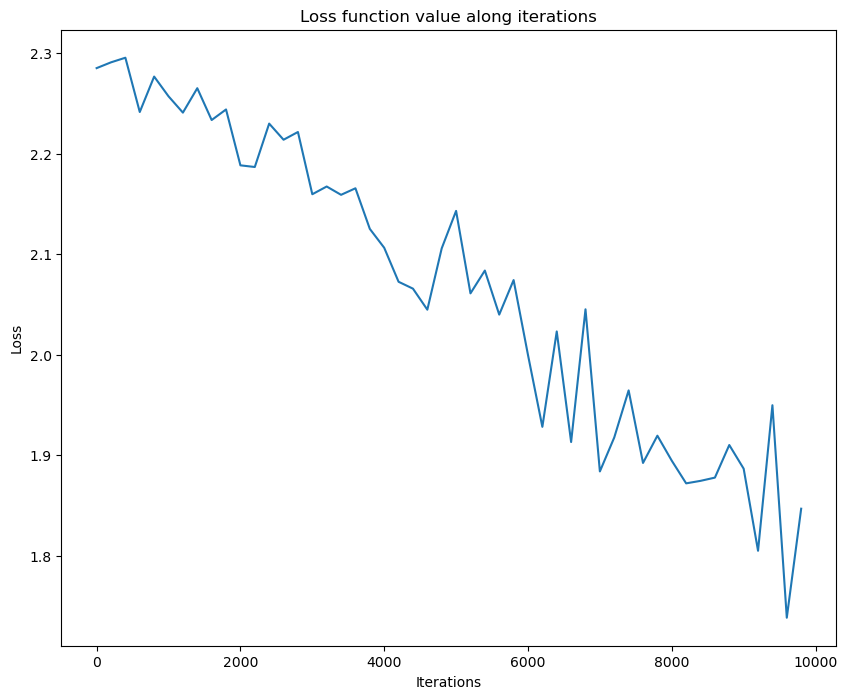

In [80]:
epochs = 10 # training epochs
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights) # length 6, in line with trainable_weights

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        # optimizer.apply_gradients(zip(grads, model.trainable_weights))
        update_item = list()
        for i in range(len(grads)):
            update_item.append(-lr * 1/batch_size * grads[i])
        update_weights(model, update_item)

        # Log every 400 batches.
        if step % 200 == 0:
            step_list.append(step)
            loss_list.append(float(loss_value))
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
plt.figure(figsize=(10,8))
plt.plot([200*k for k in range(len(loss_list))], loss_list)
plt.title("Loss function value along iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# 7. Evaluation of the Model

In [93]:
logits = model(x_train)
y_train_hat = np.argmax(logits, 1) # take the max along axis=1

In [98]:
train_acc = (y_train_hat == y_train).sum()/y_train.shape[0]

In [95]:
# prepare test data
x_test = test_data[0].reshape(-1,784).astype(float) / 255
y_test = test_data[1]

In [96]:
logits = model(x_test)
y_test_hat = np.argmax(logits, 1) # take the max along axis=1

In [99]:
test_acc = (y_test_hat == y_test).sum()/y_test.shape[0]

In [100]:
print("Training accuracy: %.3f, Test accuracy: %.3f" % (float(train_acc), float(test_acc)))

Training accuracy: 0.560, Test accuracy: 0.561
